In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as tp
import time
import tqdm
from calendar import monthrange
import calendar
from xgboost import XGBRegressor
from xgboost import plot_importance
import sklearn
from itertools import product
#from tqdm import tqdm_notebook as tqdm

In [2]:
sales_train = pd.read_csv('sales_train.csv')
print('Size of dataset before outliers: {}'.format(sales_train.shape))
sales_train = sales_train[sales_train['item_price']<100000]
sales_train = sales_train[sales_train['item_cnt_day']<1000]
sales_train = sales_train[sales_train['item_price']>0]
print('Size of dataset after removing outliers: {}'.format(sales_train.shape))
ts = time.time()
matrix = []
cols = ['date_block_num','shop_id','item_id']
for i in range(34):
    sales = sales_train[sales_train.date_block_num==i]
    matrix.append(np.array(list(product([i], sales.shop_id.unique(), sales.item_id.unique())), dtype='int16'))
    
matrix = pd.DataFrame(np.vstack(matrix), columns=cols)
matrix['date_block_num'] = matrix['date_block_num'].astype(np.int8)
matrix['shop_id'] = matrix['shop_id'].astype(np.int8)
matrix['item_id'] = matrix['item_id'].astype(np.int16)
matrix.sort_values(cols,inplace=True)
time.time() - ts
exp = sales_train.groupby(['date_block_num','item_id','shop_id'])['item_cnt_day'].sum()
exp = pd.DataFrame(exp).reset_index()
exp.rename(columns={'item_cnt_day':'item_cnt_month'}, inplace = True)
#exp.sort_values(by=['date_block_num','item_id','shop_id'], inplace = True)
matrix = pd.merge(matrix, exp, on=cols, how='left')
matrix['item_cnt_month'] = (matrix['item_cnt_month']
                                .fillna(0)#.astype(np.float16))
                                .clip(0,20) # NB clip target here
                                .astype(np.float16))
train = matrix
lags = [1,2,3,6]
train.info()

Size of dataset before outliers: (2935849, 6)
Size of dataset after removing outliers: (2935845, 6)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 10913804 entries, 0 to 10913803
Data columns (total 4 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date_block_num  int8   
 1   shop_id         int8   
 2   item_id         int16  
 3   item_cnt_month  float16
dtypes: float16(1), int16(1), int8(2)
memory usage: 145.7 MB


In [3]:
#train = pd.read_csv('train.csv')
#train = train.drop('Unnamed: 0', axis = 1)
#train.sort_values(by=['date_block_num','item_id','shop_id'], inplace = True)
#train.info()
#train.item_cnt_month = train.item_cnt_month.clip(0,20)
#lags = [1,2,3,6]

In [4]:
# prepare the test dataset to merge with the training dataset
test = pd.read_csv('test.csv')
itemcat = pd.read_csv('items.csv')
#itemcat.head()
test = test.drop('ID',axis=1)
test['date_block_num'] = 34
test['item_cnt_month'] = 0
test.sort_values(by=['shop_id','item_id'], inplace = True)
itemcat.head()
train = pd.merge(train,itemcat[['item_id','item_category_id']], on = ['item_id'], how = 'left')
train.rename(columns={'item_category_id':'item_cat'}, inplace= True)
test = pd.merge(test,itemcat[['item_id','item_category_id']], on = ['item_id'], how = 'left')
test.rename(columns={'item_category_id':'item_cat'}, inplace= True)

In [5]:
test.info()
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 214200 entries, 0 to 214199
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype
---  ------          --------------   -----
 0   shop_id         214200 non-null  int64
 1   item_id         214200 non-null  int64
 2   date_block_num  214200 non-null  int64
 3   item_cnt_month  214200 non-null  int64
 4   item_cat        214200 non-null  int64
dtypes: int64(5)
memory usage: 9.8 MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 10913804 entries, 0 to 10913803
Data columns (total 5 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date_block_num  int8   
 1   shop_id         int8   
 2   item_id         int16  
 3   item_cnt_month  float16
 4   item_cat        int64  
dtypes: float16(1), int16(1), int64(1), int8(2)
memory usage: 229.0 MB


In [6]:
#test = test.drop('ID',axis=1)
#test.head()
matrix = pd.concat([train,test], keys = ['shop_id','item_id','date_block_num'], ignore_index = True, sort= False)
matrix.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11128004 entries, 0 to 11128003
Data columns (total 5 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date_block_num  int64  
 1   shop_id         int64  
 2   item_id         int64  
 3   item_cnt_month  float64
 4   item_cat        int64  
dtypes: float64(1), int64(4)
memory usage: 424.5 MB


In [7]:
def downcast(df):
    #finding floating point columns
    float_cols = [c for c in df if df[c].dtype == 'float64']
    #finding integer columns
    int_cols = [c for c in df if df[c].dtype in ['int32','int64']]
    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols] = df[int_cols].astype(np.int16)
    return df

train = downcast(matrix)
del matrix
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11128004 entries, 0 to 11128003
Data columns (total 5 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date_block_num  int16  
 1   shop_id         int16  
 2   item_id         int16  
 3   item_cnt_month  float32
 4   item_cat        int16  
dtypes: float32(1), int16(4)
memory usage: 127.4 MB


In [8]:
train.date_block_num.unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34], dtype=int16)

In [9]:
# Function for introducing lag features in the dataset. "COL" is the intended feature
def lag_feature(df, lags, col):
    tmp = df[['date_block_num','shop_id','item_id',col]] #made a temporary dataframe
    for i in tqdm.tqdm(lags):
        shifted = tmp.copy()
        shifted.columns = ['date_block_num','shop_id','item_id', col+'_lag_'+str(i)]
        shifted['date_block_num'] += i
        df = pd.merge(df, shifted, on=['date_block_num','shop_id','item_id'], how='left')
    return df

ts = time.time()
train = lag_feature(train, lags, 'item_cnt_month')
time.time() - ts

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:27<00:00,  6.89s/it]


27.6822829246521

In [10]:
train.fillna(0, inplace = True)

In [11]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11128004 entries, 0 to 11128003
Data columns (total 9 columns):
 #   Column                Dtype  
---  ------                -----  
 0   date_block_num        int16  
 1   shop_id               int16  
 2   item_id               int16  
 3   item_cnt_month        float32
 4   item_cat              int16  
 5   item_cnt_month_lag_1  float32
 6   item_cnt_month_lag_2  float32
 7   item_cnt_month_lag_3  float32
 8   item_cnt_month_lag_6  float32
dtypes: float32(5), int16(4)
memory usage: 382.0 MB


In [12]:
#item price information is missing. lets add it
sales_train = pd.read_csv('sales_train.csv')
print('Size of dataset before outliers: {}'.format(sales_train.shape))
sales_train = sales_train[sales_train['item_price']<50000]
sales_train = sales_train[sales_train['item_cnt_day']<600]
sales_train = sales_train[sales_train['item_price']>0]
print('Size of dataset after removing outliers: {}'.format(sales_train.shape))

Size of dataset before outliers: (2935849, 6)
Size of dataset after removing outliers: (2935840, 6)


In [13]:
exp = sales_train.groupby(['shop_id','item_id','date_block_num'])['item_price'].max()

In [14]:
exp = pd.DataFrame(exp).reset_index()
exp.head(5)

,shop_id,item_id,date_block_num,item_price
0,0,30,1,265.0
1,0,31,1,434.0
2,0,32,0,221.0
3,0,32,1,221.0
4,0,33,0,347.0


In [15]:
matrix = pd.merge(train,exp,on=['shop_id','item_id','date_block_num'],how = 'left')
matrix.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1823321 entries, 0 to 1823320
Data columns (total 10 columns):
 #   Column                Dtype  
---  ------                -----  
 0   date_block_num        int64  
 1   item_id               int64  
 2   shop_id               int64  
 3   item_cnt_month        float64
 4   item_cat              int64  
 5   item_cnt_month_lag_1  float64
 6   item_cnt_month_lag_2  float64
 7   item_cnt_month_lag_3  float64
 8   item_cnt_month_lag_6  float64
 9   item_price            float64
dtypes: float64(6), int64(4)
memory usage: 153.0 MB


In [16]:
matrix.fillna(0,inplace=True)
train = matrix

In [17]:
del matrix
del exp
del test
del itemcat

In [18]:
# Price analysis. In this section we will dome some experiment on price analysis will see if there are ups and
# downs in price

In [19]:
train.columns

Index(['date_block_num', 'item_id', 'shop_id', 'item_cnt_month', 'item_cat',
       'item_cnt_month_lag_1', 'item_cnt_month_lag_2', 'item_cnt_month_lag_3',
       'item_cnt_month_lag_6', 'item_price'],
      dtype='object')

In [20]:
# we don't have any information about 34th month price. We will have to use prior information. The information about
# last time sell

In [21]:
exp = sales_train.groupby(['shop_id','item_id','date_block_num'])['item_price'].max() #all shop-item price
exp = pd.DataFrame(exp).reset_index()
exp1 = sales_train.groupby(['shop_id','item_id'])['date_block_num'].max() # extracting the immediate last sales history
exp1 = pd.DataFrame(exp1).reset_index()
matrix = pd.merge(exp1,exp, on=['shop_id','item_id','date_block_num'], how = 'inner')
matrix['date_block_num'] = 34
temp = pd.merge(train,matrix,on=['shop_id','item_id','date_block_num'], how = 'left')
temp.info()
#matrix = train[train.date_block_num==34]
#matrix = pd.merge(matrix,exp,on=['shop_id','item_id'])

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1823321 entries, 0 to 1823320
Data columns (total 11 columns):
 #   Column                Dtype  
---  ------                -----  
 0   date_block_num        int64  
 1   item_id               int64  
 2   shop_id               int64  
 3   item_cnt_month        float64
 4   item_cat              int64  
 5   item_cnt_month_lag_1  float64
 6   item_cnt_month_lag_2  float64
 7   item_cnt_month_lag_3  float64
 8   item_cnt_month_lag_6  float64
 9   item_price_x          float64
 10  item_price_y          float64
dtypes: float64(7), int64(4)
memory usage: 166.9 MB


In [22]:
temp.fillna(0,inplace=True)
temp['item_price'] = ''
temp['item_price'] = temp['item_price_x'] + temp['item_price_y']
temp = temp.drop(columns = ['item_price_x','item_price_y'], axis=1)

In [23]:
train = temp[temp.item_price>0] # shop+item duo for which data available in training set
remainder = temp[temp.item_price==0] # shop+item duo for which no data available in training set, different approach required

In [24]:
del exp
del temp
del exp1
del matrix

In [25]:
# Now we shall do some investigation on item price over both shop and time

In [26]:
exp = sales_train.groupby(['shop_id','item_id'])['item_price'].max()
exp = pd.DataFrame(exp).reset_index()
exp.rename(columns={'item_price':'max'}, inplace = True)
exp.head()

,shop_id,item_id,max
0,0,30,265.0
1,0,31,434.0
2,0,32,221.0
3,0,33,347.0
4,0,35,247.0


In [27]:
exp1 = sales_train.groupby(['shop_id','item_id'])['item_price'].min()
exp1 = pd.DataFrame(exp1).reset_index()
exp1.rename(columns={'item_price':'min'}, inplace = True)
exp1.head()

,shop_id,item_id,min
0,0,30,265.0
1,0,31,434.0
2,0,32,221.0
3,0,33,347.0
4,0,35,247.0


In [28]:
matrix = pd.merge(exp,exp1, on=['shop_id','item_id'],how = 'left')

In [29]:
matrix.head()

,shop_id,item_id,max,min
0,0,30,265.0,265.0
1,0,31,434.0,434.0
2,0,32,221.0,221.0
3,0,33,347.0,347.0
4,0,35,247.0,247.0


In [30]:
matrix['change'] = np.abs(matrix['max'] -matrix['min'])

In [31]:
matrix

,shop_id,item_id,max,min,change
0,0,30,265.0,265.0,0.0
1,0,31,434.0,434.0,0.0
2,0,32,221.0,221.0,0.0
3,0,33,347.0,347.0,0.0
4,0,35,247.0,247.0,0.0
...,...,...,...,...,...
424117,59,22154,999.0,999.0,0.0
424118,59,22155,149.0,149.0,0.0
424119,59,22162,399.0,349.0,50.0
424120,59,22164,749.0,699.0,50.0


In [32]:
# This means there is a change of item price over TIME. Now we need to see if there is variation of item price
# over the SHOPS. 

In [33]:
sales_train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [34]:
shop_matrix = sales_train.pivot_table(index=['date','item_id'], columns = 'shop_id', values = 'item_price',aggfunc= np.mean, fill_value=0)

In [35]:
shop_matrix = shop_matrix.droplevel('date',axis=0)

In [36]:
shop_matrix_2d = shop_matrix.values

In [37]:
for i in range (0,shop_matrix_2d.shape[0]):
    maxs = np.max(shop_matrix_2d[i])
    shop_matrix_2d[i] = shop_matrix_2d[i]/maxs

In [38]:
shop_matrix_2d.shape

(1541608, 60)

In [39]:
shop_index = np.zeros((60,1)) # shop_index determines the usual practice of selling a product in a shopt
for i in range(0,shop_matrix_2d.shape[1]):
    temp = shop_matrix_2d[:][i]
    shop_index[i] = np.mean(temp[temp>0])
    #shop_index[i] = np.mean(np.unique(shop_matrix_2d[:][i]))

In [40]:
train['shop_index'] = ''

In [41]:
for i in range(0,60):
    train.loc[train.shop_id==i,'shop_index'] = shop_index[i]

In [42]:
np.min(train.shop_index)

0.7208835341365462

In [43]:
def nday_month(x):
    if x<12:
        year = 2013
    if x>=12 and x<22:
        year = 2014
    if x>=22:
        year = 2015
    month = np.mod(x,12) + 1
    temp = monthrange(year,month)[1]
    return temp

In [44]:
nday_month(32)

30

In [45]:
train.head()

,date_block_num,item_id,shop_id,item_cnt_month,item_cat,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_6,item_price,shop_index
0,0,19,25,1.0,40,0.0,0.0,0.0,0.0,28.0,1
1,0,27,1,1.0,19,0.0,0.0,0.0,0.0,1890.0,1
2,0,27,2,1.0,19,0.0,0.0,0.0,0.0,2499.0,1
3,0,27,10,1.0,19,0.0,0.0,0.0,0.0,1890.0,1
4,0,27,19,1.0,19,0.0,0.0,0.0,0.0,2499.0,1


In [46]:
train['day_in_month'] = ''

In [47]:
train['day_in_month'] = train.date_block_num.apply(lambda x: nday_month(x))

In [48]:
train.head()

,date_block_num,item_id,shop_id,item_cnt_month,item_cat,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_6,item_price,shop_index,day_in_month
0,0,19,25,1.0,40,0.0,0.0,0.0,0.0,28.0,1,31
1,0,27,1,1.0,19,0.0,0.0,0.0,0.0,1890.0,1,31
2,0,27,2,1.0,19,0.0,0.0,0.0,0.0,2499.0,1,31
3,0,27,10,1.0,19,0.0,0.0,0.0,0.0,1890.0,1,31
4,0,27,19,1.0,19,0.0,0.0,0.0,0.0,2499.0,1,31


In [49]:
def wday_month(x):
    if x<12:
        year = 2013
    if x>=12 and x<22:
        year = 2014
    if x>=22:
        year = 2015
    month = np.mod(x,12) + 1
    temp = np.array(calendar.monthcalendar(year,month))[:,calendar.SATURDAY]
    return (temp>0).sum()

In [50]:
train['wday_in_month'] = ''

In [51]:
train['wday_in_month'] = train.date_block_num.apply(lambda x: wday_month(x))

In [52]:
train['month_index'] = ''

In [53]:
train['month_index'] = train.date_block_num.apply(lambda x: np.mod(x,12)+1)

In [54]:
train.head()

,date_block_num,item_id,shop_id,item_cnt_month,item_cat,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_6,item_price,shop_index,day_in_month,wday_in_month,month_index
0,0,19,25,1.0,40,0.0,0.0,0.0,0.0,28.0,1,31,4,1
1,0,27,1,1.0,19,0.0,0.0,0.0,0.0,1890.0,1,31,4,1
2,0,27,2,1.0,19,0.0,0.0,0.0,0.0,2499.0,1,31,4,1
3,0,27,10,1.0,19,0.0,0.0,0.0,0.0,1890.0,1,31,4,1
4,0,27,19,1.0,19,0.0,0.0,0.0,0.0,2499.0,1,31,4,1


In [55]:
# add previous price point as lag feature
del temp
temp = train.copy()
def lag_feature(df, lags, col):
    tmp = df[['date_block_num','shop_id','item_id',col]] #made a temporary dataframe
    for i in tqdm.tqdm(lags):
        shifted = tmp.copy()
        shifted.columns = ['date_block_num','shop_id','item_id', col+'_lag_'+str(i)]
        shifted['date_block_num'] += i
        df = pd.merge(df, shifted, on=['date_block_num','shop_id','item_id'], how='left')
    return df
temp = lag_feature(train,lags,'item_price')

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:04<00:00,  1.20s/it]


In [56]:
temp.loc[temp.item_price_lag_1.isnull(),'item_price_lag_1'] = temp.item_price

In [57]:
temp.loc[temp.item_price_lag_2.isnull(),'item_price_lag_2'] = temp.item_price_lag_1
temp.loc[temp.item_price_lag_3.isnull(),'item_price_lag_3'] = temp.item_price_lag_2
temp.loc[temp.item_price_lag_6.isnull(),'item_price_lag_6'] = temp.item_price_lag_3
#temp.loc[temp.item_price_lag_12.isnull(),'item_price_lag_12'] = temp.item_price_lag_6

In [58]:
temp

,date_block_num,item_id,shop_id,item_cnt_month,item_cat,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_6,item_price,shop_index,day_in_month,wday_in_month,month_index,item_price_lag_1,item_price_lag_2,item_price_lag_3,item_price_lag_6
0,0,19,25,1.0,40,0.0,0.0,0.0,0.0,28.0,1,31,4,1,28.0,28.0,28.0,28.0
1,0,27,1,1.0,19,0.0,0.0,0.0,0.0,1890.0,1,31,4,1,1890.0,1890.0,1890.0,1890.0
2,0,27,2,1.0,19,0.0,0.0,0.0,0.0,2499.0,1,31,4,1,2499.0,2499.0,2499.0,2499.0
3,0,27,10,1.0,19,0.0,0.0,0.0,0.0,1890.0,1,31,4,1,1890.0,1890.0,1890.0,1890.0
4,0,27,19,1.0,19,0.0,0.0,0.0,0.0,2499.0,1,31,4,1,2499.0,2499.0,2499.0,2499.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1720520,34,22145,59,0.0,37,0.0,0.0,0.0,0.0,549.0,0.999089,30,4,11,549.0,549.0,549.0,549.0
1720521,34,22154,59,0.0,37,0.0,0.0,0.0,0.0,999.0,0.999089,30,4,11,999.0,999.0,999.0,999.0
1720522,34,22162,59,0.0,40,0.0,0.0,1.0,1.0,349.0,0.999089,30,4,11,349.0,349.0,349.0,349.0
1720523,34,22164,59,0.0,37,0.0,0.0,0.0,0.0,699.0,0.999089,30,4,11,699.0,699.0,699.0,699.0


In [59]:
# We have included lag price feature under some assumption: If no previous price history can be obtained, use the present price point as the previous one
train = temp
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1720525 entries, 0 to 1720524
Data columns (total 18 columns):
 #   Column                Dtype  
---  ------                -----  
 0   date_block_num        int64  
 1   item_id               int64  
 2   shop_id               int64  
 3   item_cnt_month        float64
 4   item_cat              int64  
 5   item_cnt_month_lag_1  float64
 6   item_cnt_month_lag_2  float64
 7   item_cnt_month_lag_3  float64
 8   item_cnt_month_lag_6  float64
 9   item_price            float64
 10  shop_index            object 
 11  day_in_month          int64  
 12  wday_in_month         int64  
 13  month_index           int64  
 14  item_price_lag_1      float64
 15  item_price_lag_2      float64
 16  item_price_lag_3      float64
 17  item_price_lag_6      float64
dtypes: float64(10), int64(7), object(1)
memory usage: 329.4+ MB


In [60]:
def downcast(df):
    #finding floating point columns
    float_cols = [c for c in df if df[c].dtype == 'float64']
    #finding integer columns
    int_cols = [c for c in df if df[c].dtype in ['int32','int64']]
    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols] = df[int_cols].astype(np.int16)
    return df

train = downcast(train)
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1720525 entries, 0 to 1720524
Data columns (total 18 columns):
 #   Column                Dtype  
---  ------                -----  
 0   date_block_num        int16  
 1   item_id               int16  
 2   shop_id               int16  
 3   item_cnt_month        float32
 4   item_cat              int16  
 5   item_cnt_month_lag_1  float32
 6   item_cnt_month_lag_2  float32
 7   item_cnt_month_lag_3  float32
 8   item_cnt_month_lag_6  float32
 9   item_price            float32
 10  shop_index            object 
 11  day_in_month          int16  
 12  wday_in_month         int16  
 13  month_index           int16  
 14  item_price_lag_1      float32
 15  item_price_lag_2      float32
 16  item_price_lag_3      float32
 17  item_price_lag_6      float32
dtypes: float32(10), int16(7), object(1)
memory usage: 194.9+ MB


In [61]:
exp = train.groupby(['date_block_num','item_id'])['item_cnt_month'].mean()
exp = pd.DataFrame(exp).reset_index()
exp = exp.rename(columns={'item_cnt_month':'avg_item_sale'})
temp = pd.merge(train,exp,on=['item_id','date_block_num'],how = 'left')
temp.avg_item_sale = temp.avg_item_sale.astype(np.float32)
# adding lag feature
temp = lag_feature(temp,lags,'avg_item_sale')
temp.fillna(0,inplace=True)
temp = temp.drop(columns=['avg_item_sale'],axis=1)
train = temp
traincopy = train.copy()

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:04<00:00,  1.16s/it]


In [62]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1720525 entries, 0 to 1720524
Data columns (total 22 columns):
 #   Column                Dtype  
---  ------                -----  
 0   date_block_num        int16  
 1   item_id               int16  
 2   shop_id               int16  
 3   item_cnt_month        float32
 4   item_cat              int16  
 5   item_cnt_month_lag_1  float32
 6   item_cnt_month_lag_2  float32
 7   item_cnt_month_lag_3  float32
 8   item_cnt_month_lag_6  float32
 9   item_price            float32
 10  shop_index            float64
 11  day_in_month          int16  
 12  wday_in_month         int16  
 13  month_index           int16  
 14  item_price_lag_1      float32
 15  item_price_lag_2      float32
 16  item_price_lag_3      float32
 17  item_price_lag_6      float32
 18  avg_item_sale_lag_1   float32
 19  avg_item_sale_lag_2   float32
 20  avg_item_sale_lag_3   float32
 21  avg_item_sale_lag_6   float32
dtypes: float32(14), float64(1), int16(7)
memor

In [63]:
exp = train.groupby(['date_block_num','shop_id'])['item_cnt_month'].mean()
exp = pd.DataFrame(exp).reset_index()
exp = exp.rename(columns={'item_cnt_month':'avg_shop_sale'})
temp = pd.merge(train,exp,on=['shop_id','date_block_num'],how = 'left')
temp.avg_shop_sale = temp.avg_shop_sale.astype(np.float32)
# adding lag feature
temp = lag_feature(temp,lags,'avg_shop_sale')
temp.fillna(0,inplace=True)
temp = temp.drop(columns=['avg_shop_sale'],axis=1)

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:04<00:00,  1.20s/it]


In [64]:
train = temp
traincopy = train.copy()

In [65]:
exp = train.groupby(['date_block_num','item_cat'])['item_cnt_month'].mean()
exp = pd.DataFrame(exp).reset_index()
exp = exp.rename(columns={'item_cnt_month':'avg_cat_sale'})
temp = pd.merge(train,exp,on=['item_cat','date_block_num'],how = 'left')
temp.avg_cat_sale = temp.avg_cat_sale.astype(np.float32)
# adding lag feature
temp = lag_feature(temp,lags,'avg_cat_sale')
temp.fillna(0,inplace=True)
temp = temp.drop(columns=['avg_cat_sale'],axis=1)
train = temp
traincopy = train.copy

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:04<00:00,  1.23s/it]


In [66]:
exp = train.groupby(['date_block_num','item_id'])['item_cnt_month'].sum()
exp = pd.DataFrame(exp).reset_index()
exp = exp.rename(columns={'item_cnt_month':'tot_item_sale'})
temp = pd.merge(train,exp,on=['item_id','date_block_num'],how = 'left')
temp.tot_item_sale = temp.tot_item_sale.astype(np.float32)
# adding lag feature
temp = lag_feature(temp,lags,'tot_item_sale')
temp.fillna(0,inplace=True)
temp = temp.drop(columns=['tot_item_sale'],axis=1)
train = temp
traincopy = train.copy()

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:04<00:00,  1.29s/it]


In [67]:
exp = train.groupby(['date_block_num','shop_id'])['item_cnt_month'].sum()
exp = pd.DataFrame(exp).reset_index()
exp = exp.rename(columns={'item_cnt_month':'tot_shop_sale'})
temp = pd.merge(train,exp,on=['shop_id','date_block_num'],how = 'left')
temp.tot_shop_sale = temp.tot_shop_sale.astype(np.float32)
# adding lag feature
temp = lag_feature(temp,lags,'tot_shop_sale')
temp.fillna(0,inplace=True)
temp = temp.drop(columns=['tot_shop_sale'],axis=1)
train = temp
traincopy = train.copy()

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:05<00:00,  1.35s/it]


In [68]:
exp = train.groupby(['date_block_num','item_cat'])['item_cnt_month'].sum()
exp = pd.DataFrame(exp).reset_index()
exp = exp.rename(columns={'item_cnt_month':'tot_cat_sale'})
temp = pd.merge(train,exp,on=['item_cat','date_block_num'],how = 'left')
temp.tot_cat_sale = temp.tot_cat_sale.astype(np.float32)
# adding lag feature
temp = lag_feature(temp,lags,'tot_cat_sale')
temp.fillna(0,inplace=True)
temp = temp.drop(columns=['tot_cat_sale'],axis=1)
train = temp
traincopy = train.copy()

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:05<00:00,  1.36s/it]


In [69]:
# Price Trend Feature
matrix = train.copy()
def strend(row):
    for i in lags:
        if row['pr_trend_lag_'+str(i)]:
            return row['pr_trend_lag_'+str(i)]
    return 0

exp = matrix.groupby('item_id')['item_price'].mean()
exp = pd.DataFrame(exp)
exp = exp.reset_index()
exp = exp.rename(columns={'item_price':'avg_item_price'})
matrix = pd.merge(matrix,exp,on=['item_id'],how='left')
for i in lags:
    matrix['pr_trend_lag_'+str(i)] = ''
    matrix['pr_trend_lag_'+str(i)] = (matrix['item_price_lag_'+str(i)] - matrix['avg_item_price'])/matrix['avg_item_price']
matrix['slope_price'] = matrix.apply(strend, axis=1)
drop_item = ['avg_item_price']
for i in lags:
    drop_item += ['pr_trend_lag_'+str(i)]
matrix = matrix.drop(columns=drop_item,axis=1)
#train = matrix
#traincopy = train.copy()

In [70]:
train = matrix
traincopy = train.copy()
del matrix

In [71]:
############### MODEL PREPARATION ###################
train = traincopy
train.columns

Index(['date_block_num', 'item_id', 'shop_id', 'item_cnt_month', 'item_cat',
       'item_cnt_month_lag_1', 'item_cnt_month_lag_2', 'item_cnt_month_lag_3',
       'item_cnt_month_lag_6', 'item_price', 'shop_index', 'day_in_month',
       'wday_in_month', 'month_index', 'item_price_lag_1', 'item_price_lag_2',
       'item_price_lag_3', 'item_price_lag_6', 'avg_item_sale_lag_1',
       'avg_item_sale_lag_2', 'avg_item_sale_lag_3', 'avg_item_sale_lag_6',
       'avg_shop_sale_lag_1', 'avg_shop_sale_lag_2', 'avg_shop_sale_lag_3',
       'avg_shop_sale_lag_6', 'avg_cat_sale_lag_1', 'avg_cat_sale_lag_2',
       'avg_cat_sale_lag_3', 'avg_cat_sale_lag_6', 'tot_item_sale_lag_1',
       'tot_item_sale_lag_2', 'tot_item_sale_lag_3', 'tot_item_sale_lag_6',
       'tot_shop_sale_lag_1', 'tot_shop_sale_lag_2', 'tot_shop_sale_lag_3',
       'tot_shop_sale_lag_6', 'tot_cat_sale_lag_1', 'tot_cat_sale_lag_2',
       'tot_cat_sale_lag_3', 'tot_cat_sale_lag_6', 'slope_price'],
      dtype='object')

In [72]:
#monthly sale
exp = sales_train.groupby('date_block_num')['item_cnt_day'].sum()
monthly_sale = pd.DataFrame(exp).reset_index()
temp = pd.merge(train,monthly_sale,on=['date_block_num'],how= 'left')
temp = temp.rename(columns = {'item_cnt_day':'monthly_sale'})
temp = lag_feature(temp,lags,'monthly_sale')
temp.fillna(0,inplace= True)
temp = temp.drop(columns=['monthly_sale'],axis=1)
train = temp
traincopy = train.copy()

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:05<00:00,  1.47s/it]


In [73]:
train = traincopy
train = train.drop(columns=['item_price'],axis=1)
#train['item_cnt_month'] = train.item_cnt_month.clip(0,20)
train.fillna(0,inplace=True)
train['shop_index'] = train['shop_index'].astype(np.float32)
train = train[train['date_block_num']>= np.max(lags)]
valid_month = 33
test_month = 34
xtrain = train[train.date_block_num<valid_month].drop(columns='item_cnt_month', axis =1)
ytrain = train[train.date_block_num<valid_month]['item_cnt_month']
xvalid = train[train.date_block_num==valid_month].drop(columns='item_cnt_month', axis =1)
yvalid = train[train.date_block_num==valid_month]['item_cnt_month']
xtest = train[train.date_block_num==test_month].drop(columns='item_cnt_month', axis =1)

In [74]:
ts = time.time()
import sklearn
model = XGBRegressor(
    max_depth=12,
    n_estimators=1000,
    min_child_weight=0.5, 
    colsample_bytree=0.8, 
    subsample=0.8, 
    eta=0.1,    
    seed=42)

model.fit(
    xtrain, 
    ytrain, 
    eval_metric="rmse", 
    eval_set=[(xtrain, ytrain), (xvalid, yvalid)], 
    verbose=True, 
    early_stopping_rounds = 10)

time.time() - ts

[0]	validation_0-rmse:2.83307	validation_1-rmse:2.78112
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:2.66803	validation_1-rmse:2.66324
[2]	validation_0-rmse:2.52672	validation_1-rmse:2.55674
[3]	validation_0-rmse:2.40081	validation_1-rmse:2.48222
[4]	validation_0-rmse:2.29377	validation_1-rmse:2.40912
[5]	validation_0-rmse:2.19923	validation_1-rmse:2.34766
[6]	validation_0-rmse:2.12039	validation_1-rmse:2.29924
[7]	validation_0-rmse:2.05016	validation_1-rmse:2.26442
[8]	validation_0-rmse:1.98784	validation_1-rmse:2.22924
[9]	validation_0-rmse:1.93045	validation_1-rmse:2.20782
[10]	validation_0-rmse:1.88333	validation_1-rmse:2.17246
[11]	validation_0-rmse:1.84591	validation_1-rmse:2.14813
[12]	validation_0-rmse:1.80922	validation_1-rmse:2.13422
[13]	validation_0-rmse:1.78093	validation_1-rmse:2.11782
[14]	validation_0-rmse:1.75535	validation_1-rmse:2.10

95.0045599937439

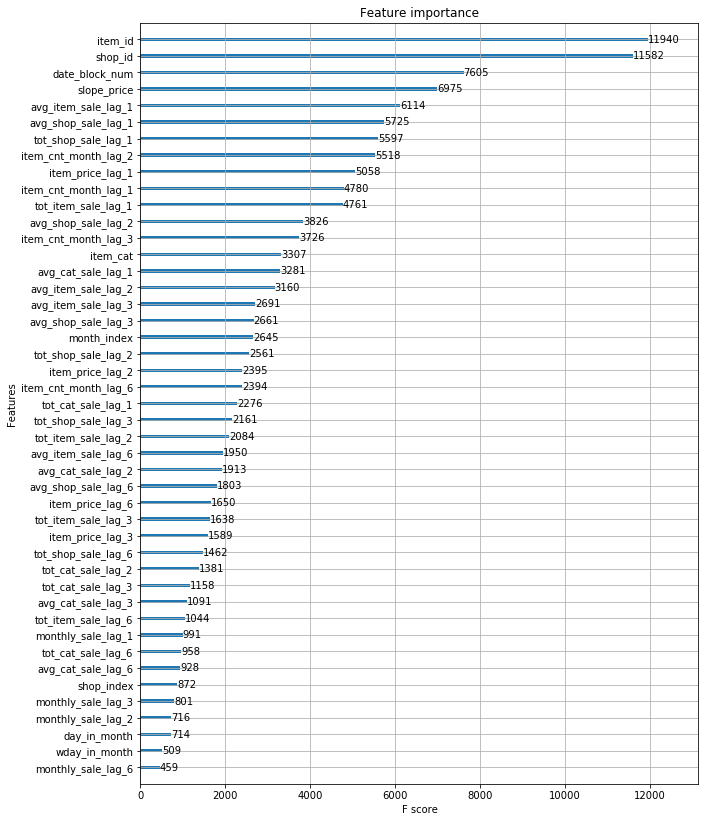

In [75]:
def plot_features(booster, figsize):    
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax)
plot_features(model, (10,14))

In [76]:
ypred = model.predict(xtest)

In [77]:
ypred

array([1.0228751, 0.9711656, 1.0630636, ..., 0.9609761, 2.1035473,
       1.4725301], dtype=float32)

In [78]:
## Preparing submission file
test = pd.read_csv('test.csv')

In [79]:
temp = xtest[['shop_id','item_id']]
temp['item_cnt_month'] = ypred

C:\Users\Tanweer\Miniconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [80]:
submission = pd.concat((remainder[['shop_id','item_id','item_cnt_month']],temp))

In [81]:
exp = pd.merge(test,submission,on=['shop_id','item_id'], how= 'left')
exp = exp.drop(columns=['shop_id','item_id'], axis = 1)
exp.item_cnt_month = exp.item_cnt_month.clip(0,20)

In [82]:
exp.to_csv('submission_xgboost1.csv', index = False)

In [83]:
train.shape

(1369259, 46)